In [80]:
import pandas as pd

df = pd.read_csv('gdc_download_20240201_205130.883037/0a72a23d-0e31-4060-8a99-c5da7e11c5ef/fa17239b-e5fb-4818-a4f7-f49d996d4a05.rna_seq.augmented_star_gene_counts.tsv', sep='\t')
df = df.reset_index()
df.columns = df.iloc[0]
df = df.drop(range(5))
df.index = df['gene_name'] + '_' + df['gene_id']
s = df['tpm_unstranded']
s.name = None
s1 = s[s.index.str.contains('^ALDOA_|^ANGPTL4_|^ANLN_|^BNC1_|^C20orf20_|^CA9_|^CDKN3_|^COL4A6_|^DCBLD1_|^ENO1_|^FAM83B_|^FOSL1_|^GNAI1_|^HIG2_|^KCTD11_|^KRT17_|^LDHA_|^MPRS17_|^P4HA1_|^PGAM1_|^PGK1_|^SDC1_|^SLC16A1_|^SLC2A1_|^TPI1_|^VEGFA_')]
s2 = s[s.index.str.contains('^HLA-DQA1_|^HLA-DQA2_|^HLA-DRB5_|^CTLA4_|^PDCD1LG2_|^ICAM1_|^CD274_|^STAT1_|^IRF1_|^IFNG_|^GNLY_|^TBX21_|^CCL5_|^LAG3_|^CD247_|^ICOS_|^IL18RAP_|^CXCL9_|^CXCL10_|^HLA-DPB1_|^HLA-DPA1_|^HLA-DMB_|^HLA-DRA_|^HLA-DMA_|^CD80_|^HLA-DOA_|^CD4_')]

In [59]:
from ipywidgets import IntProgress
from IPython.display import display

import os
import pandas as pd

path = 'gdc_download_20240201_205130.883037'
folders = [entry.name for entry in os.scandir(path) if entry.is_dir()]
files = []
files1 = []
files2 = []

bar = IntProgress(min=0, max=len(folders))
display(bar)

for folder in folders:
    file = [entry.name for entry in os.scandir(path + '/' + folder) if entry.is_file() and entry.name[-4:] == '.tsv'][0]

    df = pd.read_csv(path + '/' + folder + '/' + file, sep='\t')
    df = df.reset_index()
    df.columns = df.iloc[0]
    df = df.drop(range(5))
    df.index = df['gene_name'] + '_' + df['gene_id']
    s = df['tpm_unstranded']
    s.name = None
    s1 = s[s.index.str.contains('^ALDOA_|^ANGPTL4_|^ANLN_|^BNC1_|^C20orf20_|^CA9_|^CDKN3_|^COL4A6_|^DCBLD1_|^ENO1_|^FAM83B_|^FOSL1_|^GNAI1_|^HIG2_|^KCTD11_|^KRT17_|^LDHA_|^MPRS17_|^P4HA1_|^PGAM1_|^PGK1_|^SDC1_|^SLC16A1_|^SLC2A1_|^TPI1_|^VEGFA_')]
    s2 = s[s.index.str.contains('^HLA-DQA1_|^HLA-DQA2_|^HLA-DRB5_|^CTLA4_|^PDCD1LG2_|^ICAM1_|^CD274_|^STAT1_|^IRF1_|^IFNG_|^GNLY_|^TBX21_|^CCL5_|^LAG3_|^CD247_|^ICOS_|^IL18RAP_|^CXCL9_|^CXCL10_|^HLA-DPB1_|^HLA-DPA1_|^HLA-DMB_|^HLA-DRA_|^HLA-DMA_|^CD80_|^HLA-DOA_|^CD4_')]

    files.append(s)
    files1.append(s1)
    files2.append(s2)

    bar.value += 1

df = pd.concat(files, axis=1).T
df['file_id'] = folders
df1 = pd.concat(files1, axis=1).T
df1['file_id'] = folders
df2 = pd.concat(files2, axis=1).T
df2['file_id'] = folders

IntProgress(value=0, max=565)

In [81]:
#df3 = pd.concat([df1.drop(columns=['file_id']), df2], axis=1)
#df.to_csv('rnaseq_all.tsv', sep='\t', index=False)
#df1.to_csv('rnaseq_s1.tsv', sep='\t', index=False)
#df2.to_csv('rnaseq_s2.tsv', sep='\t', index=False)
#df3.to_csv('rnaseq_s1_s2.tsv', sep='\t', index=False)

In [74]:
import json
import pandas as pd

meta = json.load(open('metadata.cart.2024-02-01.json'))
file_id = []
case_id = []
for i in meta:
    file_id.append(i['file_id'])
    case_id.append(i['associated_entities'][0]['case_id'])

#pd.DataFrame({'case_id': case_id, 'file_id': file_id}).to_csv('file_to_case.tsv', sep='\t', index=False)

In [82]:
df = pd.read_csv('rnaseq_s1.tsv', sep='\t')
df = pd.merge(df, pd.read_csv('file_to_case.tsv', sep='\t'), on='file_id', how='left')
df = pd.merge(df, pd.read_csv('output.csv'), on='case_id', how='left')

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=['file_id', 'case_id', 'vital_status']).apply(pd.to_numeric)
y = df['vital_status'].map({'Alive': True, 'Dead': False})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X = MinMaxScaler().fit_transform(X)

18/18 [==============================] - 0s 314us/step


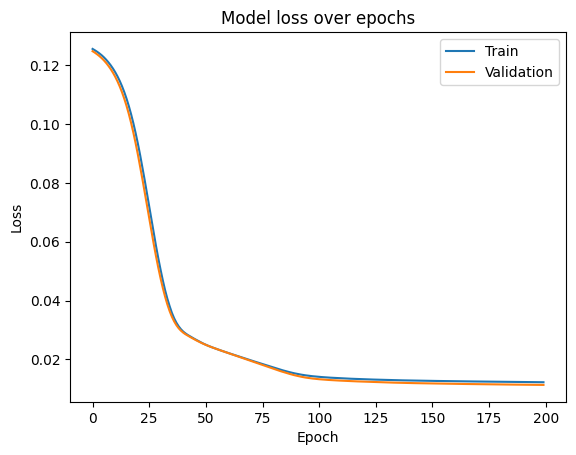

In [125]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

input_img = Input(shape=(23,))
encoded = Dense(20, activation='relu')(input_img)
encoded = Dense(15, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)
decoded = Dense(15, activation='relu')(encoded)
decoded = Dense(20, activation='relu')(decoded)
decoded = Dense(23, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
decoder = Model(encoded, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(X, X,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                verbose=0)

encoded_imgs = encoder.predict(X)
"""
principal_components = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(encoded_imgs))
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
plt.scatter(principal_df['PC1'], principal_df['PC2'], c=y, cmap='viridis')
plt.show()
"""

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [152]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense

import matplotlib.pyplot as plt

input_img = Input(shape=(23,))
encoded = Dense(20, activation='relu')(input_img)
encoded = Dense(15, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)
decoded = Dense(15, activation='relu')(encoded)
decoded = Dense(20, activation='relu')(decoded)
decoded = Dense(23, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
decoder = Model(encoded, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(X, X,
                epochs=120,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                verbose=0)

encoded_imgs = encoder.predict(X)

18/18 [==============================] - 0s 313us/step


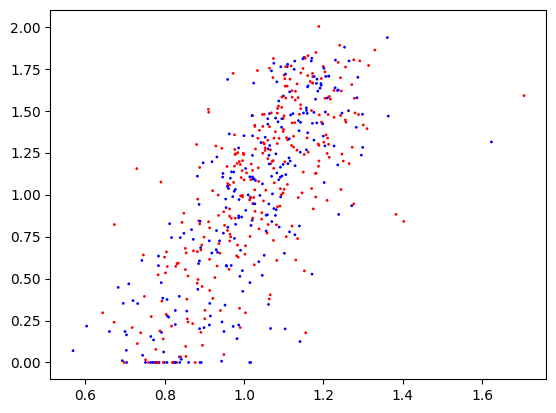

In [159]:
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y, cmap='bwr', s=1)
plt.show()